In [1]:
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')
# Generic python
import matplotlib.pyplot as plt
import numpy as np

# Bonus vector manipulation
import pandas as pd
#from pandas import Dataframe
import geopandas as gpd
from shapely import wkt
from datetime import datetime

# **Landsat-8 WOFS Product Creation**

### Config

Import required DC utils

In [3]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

In [11]:
import datacube
# DC utilities
from datacube_utilities.clean_mask import landsat_qa_clean_mask
from datacube_utilities.dc_water_classifier import wofs_classify
from datacube_utilities.import_export import export_xarray_to_netcdf

Define aoi via wkt polygon (could be subbed or shapefile)

In [28]:
#aoi_wkt = "POLYGON((178.12 -18.25,178.15 -18.25,178.15 -18.27,178.12 -18.27,178.12 -18.25))"
#testarea
#aoi_wkt = "POLYGON((177.75226467901712 -17.879622210337537,177.80204647833352 -17.879622210337537,177.80204647833352 -17.914988456071715,177.75226467901712 -17.914988456071715,177.75226467901712 -17.879622210337537))"
#whole country
#aoi_wkt = "POLYGON((177.21496582032 -17.254028320312, 178.76403808594 -17.259521484375, 178.76953125001 -18.286743164062, 177.19848632813 -18.286743164062, 177.21496582032 -17.254028320312))"
#aoi_wkt = "POLYGON((178.24905395508 -18.036804199219, 178.51547241212 -18.038177490235, 178.51547241212 -18.220825195313, 178.25454711915 -18.220825195313, 178.24905395508 -18.036804199219))"
#aoi_wkt = "POLYGON((178.11035156251 -17.841796875, 178.83544921876 -17.830810546875, 178.83544921876 -18.297729492187, 178.10485839844 -18.30322265625, 178.11035156251 -17.841796875))"
#aoi_wkt = "POLYGON ((177.4134063720703 -17.884005713834192, 177.77938842773435 -17.884005713834192, 177.77938842773435 -17.616537468641294, 177.4134063720703 -17.616537468641294, 177.4134063720703 -17.884005713834192))"
#aoi_wkt = "POLYGON((177.34096527101 -17.746353149414, 177.43160247804 -17.744293212891, 177.4364089966 -17.834930419922, 177.34165191652 -17.833557128906, 177.34096527101 -17.746353149414))"
#aoi_wkt = "POLYGON((177.34096527101 -17.746353149414, 177.43160247804 -17.744293212891, 177.4364089966 -17.834930419922, 177.34165191652 -17.833557128906, 177.34096527101 -17.746353149414))"
aoi_wkt = "POLYGON((177.34096527101 -17.746353149414, 177.43160247804 -17.744293212891, 177.4364089966 -17.834930419922, 177.34165191652 -17.833557128906, 177.34096527101 -17.746353149414))"
aoi = gpd.GeoDataFrame(pd.DataFrame({'geoms':[wkt.loads(aoi_wkt)]}), geometry='geoms')

In [29]:
dc = datacube.Datacube(app="na")

In [30]:
area_json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.maxy.values[0]
            ],
            [
                aoi.bounds.maxx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.miny.values[0]
            ],
            [
                aoi.bounds.minx.values[0],
                aoi.bounds.maxy.values[0]
            ]
          ]
        ]
      }
    }
  ]
}

In [31]:
lons, lats = zip(*area_json["features"][0]["geometry"]["coordinates"][0])
lat_extents = (min(lats), max(lats))
lon_extents = (min(lons), max(lons))
print("Lat:", lat_extents, "\n"
      "Lon:", lon_extents)

Lat: (-17.834930419922, -17.744293212891) 
Lon: (177.34096527101, 177.4364089966)


### Load Data

Generic query specs

In [34]:
query = dict(   latitude = lat_extents,
                longitude = lon_extents,
                output_crs = "EPSG:32760",
                time = (datetime(2019,5,10), datetime(2019,5,30)),
                resolution = (30,30))


Dataset-specifics

In [35]:
scenes = dc.load(product="ls8_usgs_sr_scene",
               group_by='solar_day',
               measurements = ["green","red", "blue", "nir","swir1","swir2","pixel_qa"],
               **query)
#scenes = dc.find_datasets(product="ls8_usgs_sr_scene",
#               group_by='solar_day',
#               measurements = ["green","red","blue","nir","swir1","swir2","coastal_aerosol","pixel_qa"],
#               **query)

We've been testing removal of no-data value to nan. This doesn't seem to work though as outputs from wofs over nan areas is 0, which skews the total no. observations.

In [36]:
#scenes = scenes.where(scenes != -9999.) 
scenespd = pd.DataFrame(scenes)
print(scenespd.head())

       0
0  green
1    red
2   blue
3    nir
4  swir1


Check loaded

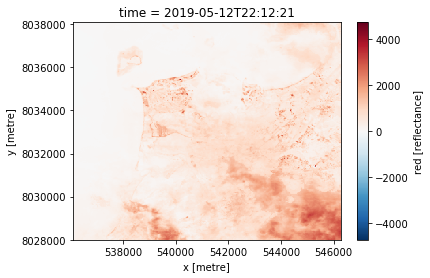

In [37]:
scenes.isel(time = 0).red.plot();

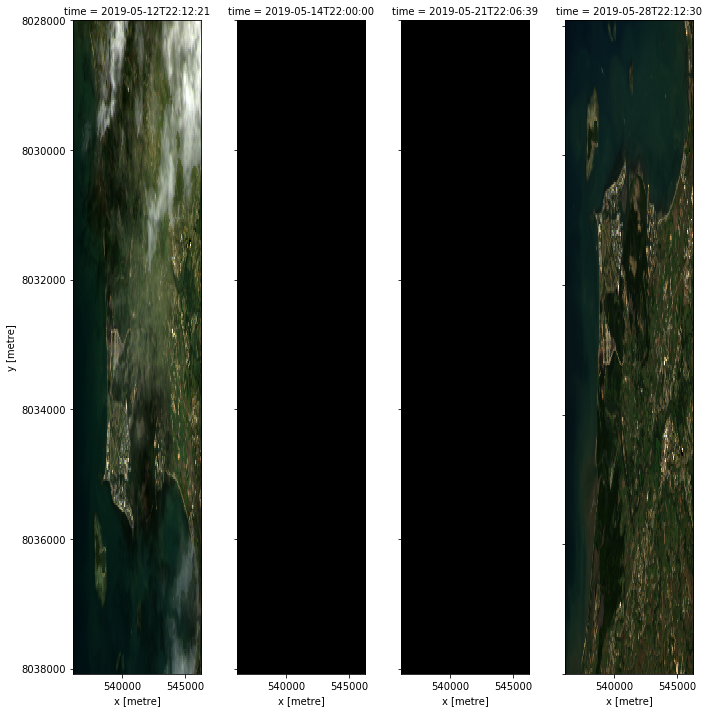

In [38]:
# Plot as RGB image
scenes[['red','green','blue']].to_array().plot.imshow(
    col='time',
    figsize=(10, 10),
    vmin=0,
    vmax=3000
);

Create + apply 'cleansky' mask

In [45]:
clearsky_masks = landsat_qa_clean_mask(scenes, 'LANDSAT_8')
clearsky_scenes = scenes.where(clearsky_masks)

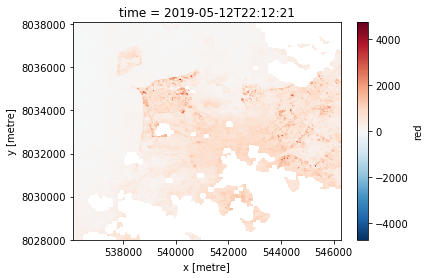

In [46]:
clearsky_scenes.isel(time = 0).red.plot();

Apply wofs classification

In [47]:
water_classes = wofs_classify(scenes, clean_mask=clearsky_masks.values , no_data = np.nan , x_coord='x', y_coord = "y")

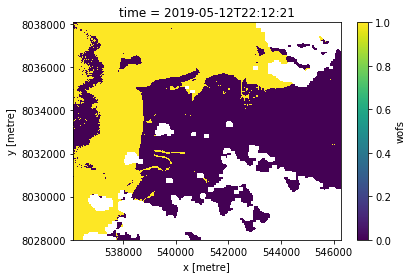

In [48]:
water_classes.isel(time = 0).wofs.plot();

Visualise wofs summary product

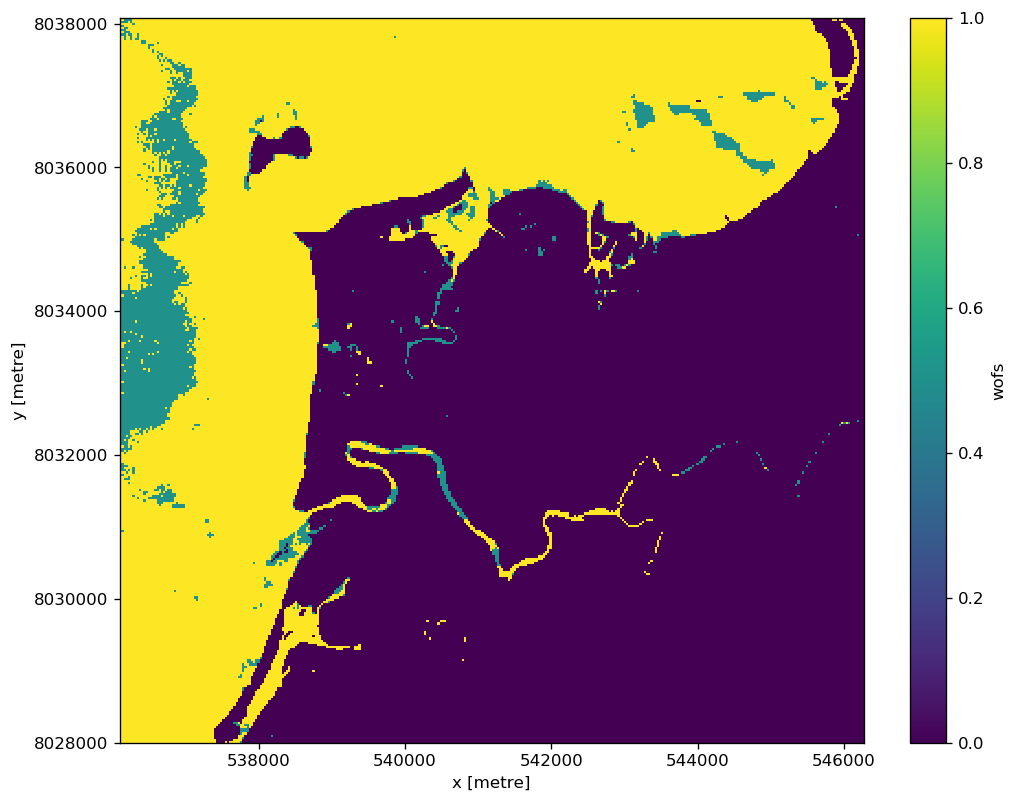

In [49]:
plt.figure(figsize = (10,8), dpi=120)
water_classes.wofs.mean(dim = 'time').plot();

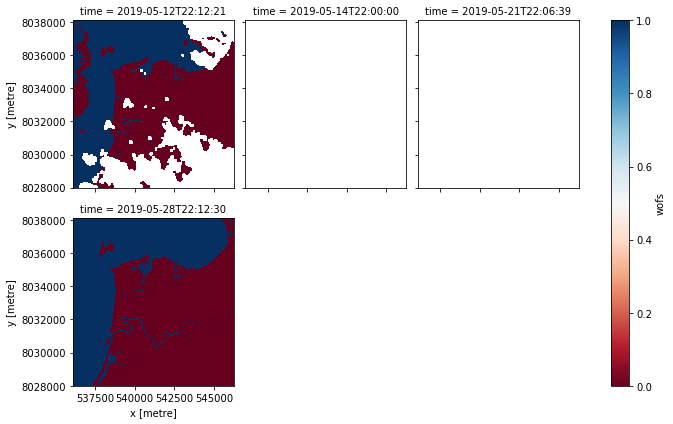

In [50]:
water_classes.wofs.plot(col='time', cmap='RdBu', col_wrap=3, vmin=0, vmax=1)

### Export to file within shared storage

Define output path

In [22]:
# Ensure the output directory exists before writing to it.
!mkdir -p /home/shared/geo_demos/wofs_testers
output_file_name  =  "/home/shared/geo_demos/wofs_testers/l8_indiv.nc"

Correct attributes and add to wofs xarray (for some reason we have 'dc_partual_load' as true...)

In [17]:
scenes.attrs

OrderedDict([('crs', CRS('EPSG:32760'))])

In [18]:
# at = scenes.attrs
# del at['dc_partial_load']
# at

In [19]:
dataset_to_output =  water_classes.assign_attrs(scenes.attrs)

In [20]:
dataset_to_output.attrs

OrderedDict([('crs', CRS('EPSG:32760'))])

Export

In [21]:
export_xarray_to_netcdf(dataset_to_output, output_file_name)
#export_xarray_to_netcdf